# Campaign Analysis

Description

The objective of the team is to build a predictive model that will produce the highest profit for the next direct marketing campaign, scheduled for the next month. The next campaign, aims at selling a new gadget to the Customer Database. To build the model, a pilot campaign involving 2.240 customers was carried out. The customers were selected at random and contacted by phone regarding the acquisition of the gadget. During the following months, customers who bought the offer were properly labeled. The total cost of the sample campaign was 6.720MU and the revenue generated by the customers who accepted the offer was 3.674MU. Globally the campaign had a profit of -3.046MU. 

In [1]:
!kaggle datasets download -d rodsaldanha/arketing-campaign

Dataset URL: https://www.kaggle.com/datasets/rodsaldanha/arketing-campaign
License(s): other
arketing-campaign.zip: Skipping, found more recently modified local copy (use --force to force download)


In [2]:
# import relevant libraries

import pandas as pd
import numpy as np
import zipfile
from sklearn.impute import KNNImputer
import datetime
import plotly.express as px
from matplotlib import pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples,silhouette_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from IPython.display import display

In [3]:
file = 'arketing-campaign.zip'

with zipfile.ZipFile(file, 'r') as data:
    data.extractall()

In [4]:
# show all columns
# read in data

pd.set_option('display.max_columns', None)
df = pd.read_excel('marketing_campaign.xlsx')
df.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0


#### Data Preprocessing

This step involves trying to understand the data, feature engineering, data cleaning - handling missing values, outliers, correcting datatypes.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

Feature Engineering

New columns are created from existing ones -
* Spent - The total amount spent on purchases
* Is_Parent - The parent status of customers based on if they have a kid/teen living with them
* Age - Customer's age based on their birth year
* Marital_Status - The options in this field will be corrected and reduced to 4 relevant statuses
* Total_Purchaes - The total number of purchases made per customer
* Accepted - The customers that accepted any of the marketing campaigns

In [6]:
# Create a column for the total amount spent on purchases

df['Spent'] = df['MntFishProducts'] + df['MntFruits'] + df['MntGoldProds'] + df['MntMeatProducts'] + df['MntSweetProducts'] + df['MntWines']

In [7]:
# Create new column 'is_parent' based on 'teenhome' and 'kidhome'

df['is_parent'] = np.where((df['Teenhome'] > 0) | (df['Kidhome'] > 0), 'Yes', 'No')

In [8]:
# Get the current year
current_year = datetime.datetime.now().year

# Create new column 'Age' based on 'Year_Birth'
df['Age'] = current_year - df['Year_Birth']

In [9]:
# Replace 'Together' with 'Married' and 'Alone', 'Absurd', 'YOLO' with 'Single'

df['Marital_Status'] = df['Marital_Status'].replace({'Together': 'Married', 'Alone': 'Single', 'Absurd': 'Single', 'YOLO': 'Single'})

In [10]:
# Create the new column 'Accepted' based on the acceptance of any campaign offer

df['Accepted'] = df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Response']].any(axis=1).map({True: 'Yes', False: 'No'})

In [11]:
# Creata a column for the total number of purchases made

df['Total_Purchases'] = df['NumDealsPurchases'] + df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] 

Data Cleaning

The data will be checked for duplicates, null values and outliers. 

In [12]:
# check for duplicates

df.duplicated().sum()

0

In [13]:
# check for null values

df.isnull().sum()

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
Spent                   0
is_parent               0
Age                     0
Accepted                0
Total_Purchases         0
dtype: int64

In [14]:
df.shape

(2240, 34)

There appears to be 24 missing values from the Income field. 24 might seem insignificant enough to drop them all, but the dataset of just 2240 entries might benefit from keeping them. Values for these empty cells be generated and filled using K-Nearest Neighbor Imputation.

Here, KNN Imputation works by imputing the average income of the 5 nearest neighbors found in the training set for each missing value. Age,Spent, Total_Purchases and Income will be used for this.

In [15]:
# Fill null values using KNNImputer

selected_data = df[['Income', 'Age', 'Spent', 'Total_Purchases', 'Recency']]

imputer = KNNImputer(n_neighbors=5, metric='nan_euclidean')

# fit on the dataset

imputer.fit(selected_data)

# transform the dataset

transformed = imputer.transform(selected_data)

Income_impute=pd.DataFrame(transformed,columns=['Income', 'Age', 'Spent', 'Total_Purchases', 'Recency'])

df['Income']=Income_impute['Income'].reset_index(drop=True)

In [16]:
# check that there's no more null values

df.isnull().sum()

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
Spent                  0
is_parent              0
Age                    0
Accepted               0
Total_Purchases        0
dtype: int64

The Describe function returns the statistical summary of the dataframe - stats. This is used to understand the numerical values a little more.

In [17]:
# Statistical Analysis 

stats = df[['Age', 'Income', 'Spent', 'Total_Purchases', 'Recency']]
stats.describe()

,Age,Income,Spent,Total_Purchases,Recency
count,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000
mean,55.194196,52237.879375,605.798214,14.862054,49.109375
std,11.984069,25093.744728,602.249288,7.677173,28.962453
min,28.000000,1730.000000,5.000000,0.000000,0.000000
25%,47.000000,35409.000000,68.750000,8.000000,24.000000
50%,54.000000,51371.000000,396.000000,15.000000,49.000000
75%,65.000000,68468.250000,1045.500000,21.000000,74.000000
max,131.000000,666666.000000,2525.000000,44.000000,99.000000


Handling Outliers



An outlier is a data point that differs significantly from other observations. If a value has a high enough or low enough z score, it can be considered an outlier.

In [18]:
# List of variables for boxplots
variables = ["Age", "Income", "Spent", "Total_Purchases", "Recency"]

# Loop through each variable and create a boxplot
for var in variables:
    fig = px.box(df, y=var)
    
    fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ))

    fig.show()

From the four field analysed, outliers can be seen:

* Age: There customers aged between 124 and 131 do not seem that out of pocket. These will be left in.
* Income : While several value are above the Upper Fence of 113K. Only the income of 666k is an extreme outlier. It will be assumed to be an error  and changed to 66k.
* Spent : There is only one outlier which is at the limit of the Upper Fence and will not be removed.
* Total_Purchases: Two values fall above the upper limit but are not extreme outliers so will not be removed.
* Recency : Has no outliers

In [19]:
# replace 666666 with 66666

df['Income'] = df['Income'].replace(666666, 66666)

In [20]:
# Round up the values in the 'income' column and convert to integers

df['Income'] = df['Income'].apply(lambda x: int(math.ceil(x)))

The income field is grouped into four levels - low_threshold, lower_middle_threshold, upper_middle_threshold, and high_threshold

In [21]:
# Define the thresholds for income levels

low_threshold = 1730
lower_middle_threshold = 40000
upper_middle_threshold = 80000
high_threshold = 162397

# Create a function to categorize income into levels
def categorize_income(income):
    if income < low_threshold:
        return 'Low'
    elif low_threshold <= income < lower_middle_threshold:
        return 'Lower-Middle'
    elif lower_middle_threshold <= income < upper_middle_threshold:
        return 'Upper-Middle'
    else:
        return 'High'

# Apply the function to create a new column for income levels
df['Income_Level'] = df['Income'].apply(categorize_income)

In [22]:
# drop original date column and other unnecessary columns

df.drop(['Dt_Customer', 'ID', 'Z_CostContact', 'Z_Revenue', 'Year_Birth'], axis=1, inplace=True)

#### Data Visualizations

In [23]:
education_income = df.groupby('Education')['Income'].mean().reset_index()

fig = px.bar(education_income, y='Education', x='Income',
            title='Average Income by Education Level', 
            labels={'Education': 'Education Level', 'Income': 'Average Income'}, orientation='h', color='Education')


fig.show()

In [24]:
fig = px.sunburst(df, path=['is_parent', 'Income_Level', 'Education'], 
                    labels={'Parent': 'is_parent', 'Income': 'Income_Level'}, 
                    title='Distribution of Parents by Income and Educational Level')
fig.show()

In [25]:
fig = px.sunburst(df, path=['is_parent', 'Education'], 
                    labels={'Parent': 'is_parent', 'Education': 'Education'}, 
                    title='Distribution of Parents by Educational Level')
fig.show()

In [26]:
fig = px.sunburst(df, path=['Marital_Status', 'Education'], 
                    labels={'Status': 'Marital_Status', 'Education': 'Education'}, 
                    title='Distribution of Marital Status by Educational Level')
fig.show()

In [27]:
df_plot = df.groupby(['Marital_Status'])['Spent'].mean().reset_index()

fig4 = px.bar(df_plot, x='Spent', y='Marital_Status', color='Marital_Status', orientation='h', 
                    title='Distribution of Marital Status by Money Spent')

fig4.show()

In [28]:
# Group by 'Marital_Status' and sum 'Total_Purchases'
marital_purchases = df.groupby('Marital_Status')['Total_Purchases'].mean().reset_index()

# Create the bar chart
fig = px.bar(marital_purchases, x='Total_Purchases', y='Marital_Status', orientation='h',
             labels={'Total_Purchases': 'Total Purchases', 'Marital_Status': 'Marital Status'},
             title='Total Purchases by Marital Status', color='Marital_Status')

fig.show()

In [29]:
fig = px.sunburst(df, path=['Marital_Status', 'Income_Level'], 
                    labels={'Marital Status': 'Marital_Status', 'Income': 'Income_Level'}, 
                    title='Distribution of Marital Status by Income Level')
fig.show()

In [30]:
fig = px.scatter(df, x="Spent", y="Income", 
                    title='Correlation of Money Spent and Income')
fig.show()

Marketing Campaign Response. Visualizing those who accepted the campaign offers by;

- Parent - The dataset has more parents than non-parents. More parents accepted the offers than non-parents
- Age group - People aged 50-59 accepted the most offers. Across all age groups, more people rejected the offers than accepted.
- Educational level - More graduates accepted the campaign compared to any other educational level.
- Campaign - The 4th campaign converted the most customers and the 2nd campaign the least.

In [31]:
fig = px.sunburst(df, path=['is_parent', 'Accepted'], title='Distribution of Parents who Accepted Campaign Offers', labels=['is_parent'])
fig.show()

In [32]:
# Classify ages into bins
bins = [20, 30, 40, 50, 60, 70, 80, 90, 100, 110]
labels = ['20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90-99', '100+']
df['Age_Group'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Group by 'Accepted' and 'Age_Group' to get the counts
age_campaign = df.groupby(['Accepted', 'Age_Group']).size().reset_index(name='Counts')

# Create the bar chart
fig = px.bar(age_campaign, x='Age_Group', y='Counts', color='Accepted', barmode='group', 
             labels={'Accepted': 'Accepted Campaign', 'Counts': 'Number of People'}, 
             title='Distribution of Campaign Responses by Age Group')

fig.show()

/var/folders/xy/b785rtgn795129srfj5kb0mc0000gn/T/ipykernel_46001/3042331969.py:7: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



In [33]:
fig = px.sunburst(df, path=['Accepted', 'Education'], title='Distribution of Campaign Responses by Educational Level')
fig.show()

In [34]:
# Sum the values in each campaign column to get the count of accepted offers
campaign_counts = df[['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']].sum()

# Plot a pie chart
fig = px.pie(values=campaign_counts.values, names=campaign_counts.index, 
             title='Distribution of Accepted Offers per Campaign')
fig.show()

Correlation  Analysis

Plotting heatmaps to visualize the correlation between products bought and items purchased with the campaign acceptance rate. There is generally a weak correlation between the selected fields.

<Figure size 1000x800 with 0 Axes>

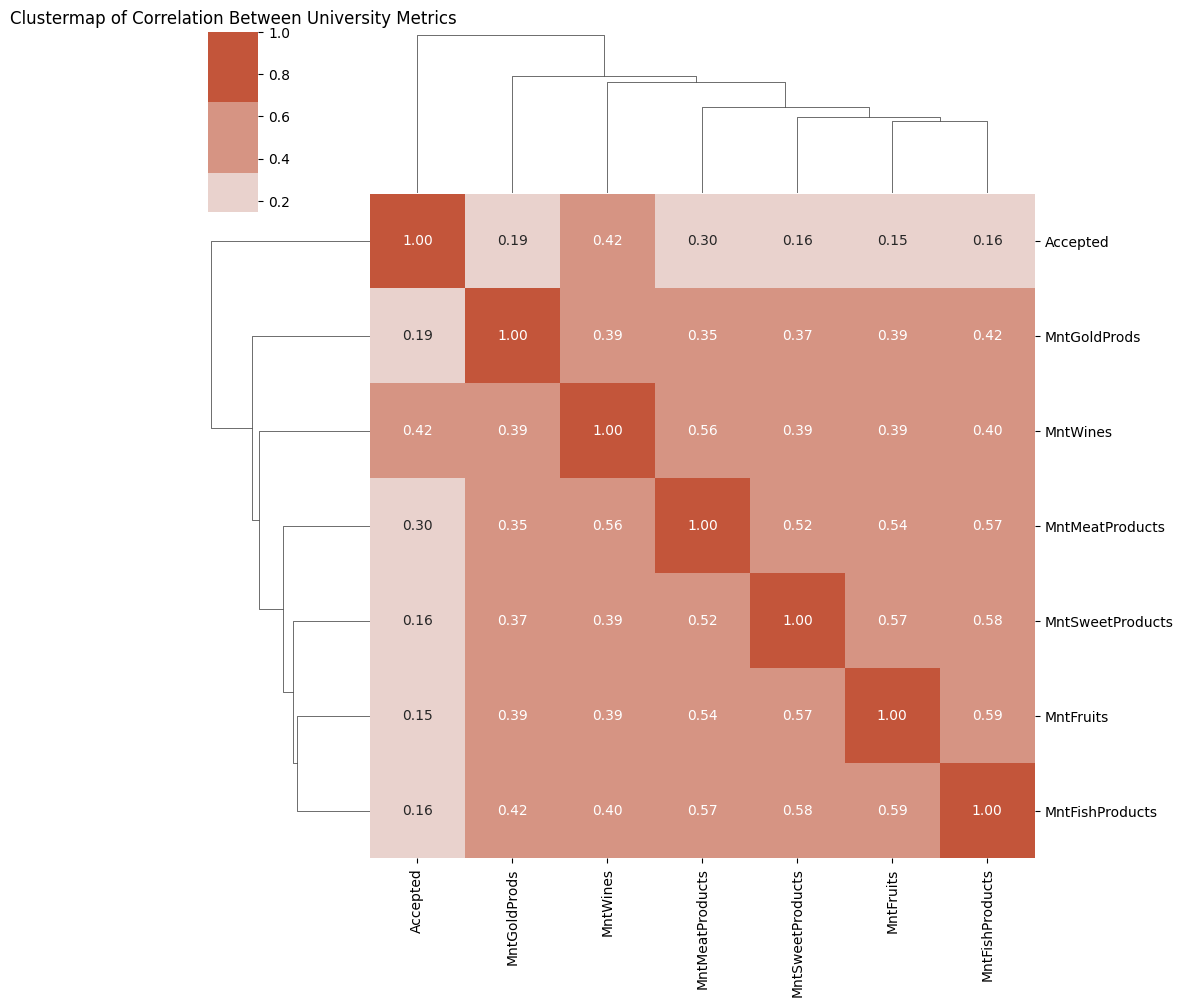

In [35]:
df['Accepted'] = df['Accepted'].map({'Yes': 1, 'No': 0})

# Select the relevant columns for correlation analysis
columns_of_interest = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'Accepted']

data_selected = df[columns_of_interest]

# Create the clustermap
plt.figure(figsize=(10,8))
sns.clustermap(data_selected.corr(), annot=True, fmt='.2f', cmap=sns.diverging_palette(h_neg=220, h_pos=20), center=0)
plt.title('Clustermap of Correlation Between University Metrics')
plt.show()

<Figure size 1000x800 with 0 Axes>

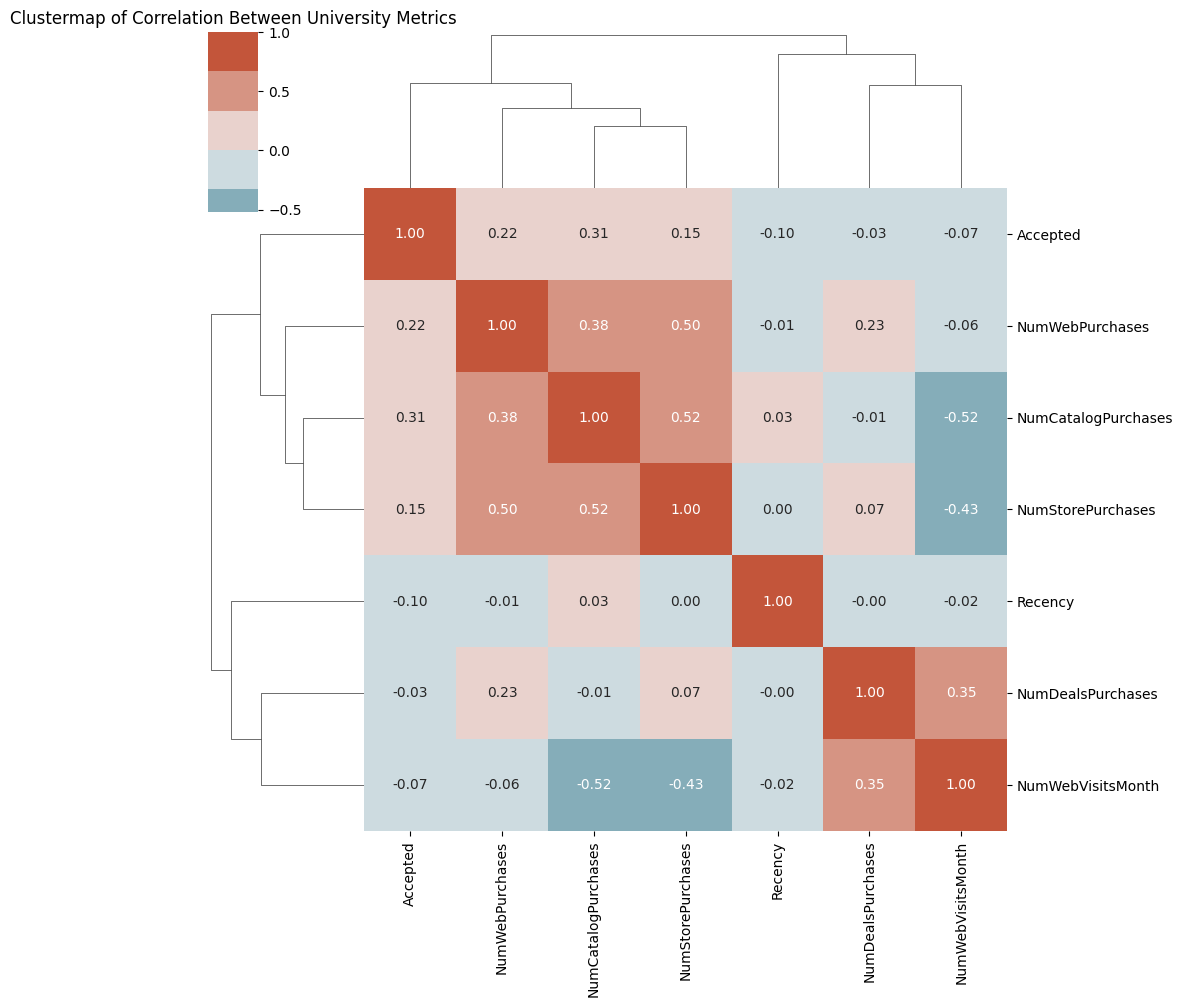

In [36]:
# Select the relevant columns for correlation analysis
columns_of_interest = ['NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Recency', 'Accepted']

data_selected = df[columns_of_interest]

# Create the clustermap
plt.figure(figsize=(10,8))
sns.clustermap(data_selected.corr(), annot=True, fmt='.2f', cmap=sns.diverging_palette(h_neg=220, h_pos=20), center=0)
plt.title('Clustermap of Correlation Between University Metrics')
plt.show()

#### Clustering

Customer segmentation aims to categorize customers based on common characteristics. This clustering analysis will focus on features - Age, Spent, Income, Total Purchased, Recency.

Data Preprocessing

Data Preprocessing will involve standardizing the numerical variables and encoding the categorical variables. Standardization ensures all variables are scaled and contribute equally to the model to prevent bias. Encoding converts categorical or textual data into numerical format, so that it can be used as input for algorithms to process. Data preprocessing is done to ensure the data can be inputed in the machine learning algorithms and will yield optimal results.

In [37]:
# Select fields to be standardized 

col_names = ['Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 
             'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Age', 'Income', 'Spent', 'Total_Purchases']
features = df[['Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 
               'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'Age', 'Income', 'Spent', 'Total_Purchases']]

scaler = StandardScaler()
scaled_data = scaler.fit_transform(features.values)

scaled_features = pd.DataFrame(scaled_data, columns=col_names)
scaled_features.head()

,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Income,Spent,Total_Purchases
0,0.307039,0.983781,1.551577,1.679702,2.462147,1.476500,0.843207,0.349414,1.409304,2.510890,-0.550785,0.693904,0.985345,0.287302,1.679417,1.320826
1,-0.383664,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,-0.729006,-0.168236,-1.110409,-0.568720,-1.166125,-0.130463,1.235733,-0.262059,-0.961275,-1.154596
2,-0.798086,0.362723,0.570804,-0.177032,1.345274,-0.146905,-0.038766,-0.685887,1.409304,-0.226541,1.295237,-0.542647,0.317643,0.914964,0.282673,0.799685
3,-0.798086,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,-0.748179,-0.168236,-0.750450,-0.910898,-0.550785,0.281720,-1.268149,-1.179586,-0.918094,-0.894025
4,1.550305,-0.389085,0.419916,-0.216914,0.155164,-0.001525,-0.556446,1.384715,0.329427,0.115638,0.064556,-0.130463,-1.017761,0.294522,-0.305254,0.539114


Encode Catregorical Variables

In [38]:
# Select categorical variables
categorical = df[['Education', 'Marital_Status', 'is_parent', 'Accepted']]

# Concatenate scaled features and categorical variables
data = pd.concat([scaled_features, categorical], axis=1)

newdf = pd.get_dummies(data, columns=['Education', 'Marital_Status', 'is_parent'], drop_first=False)

newdf = newdf.drop(['is_parent_No'],axis=1)

columns_to_convert = ['Education_2n Cycle', 'Education_Basic', 'Education_Graduation', 'Education_Master', 'Education_PhD', 'Marital_Status_Single', 'Marital_Status_Married', 'Marital_Status_Divorced', 'Marital_Status_Widow', 'is_parent_Yes']
newdf[columns_to_convert] = newdf[columns_to_convert].astype(int)
newdf.head()

,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Income,Spent,Total_Purchases,Accepted,Education_2n Cycle,Education_Basic,Education_Graduation,Education_Master,Education_PhD,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Widow,is_parent_Yes
0,0.307039,0.983781,1.551577,1.679702,2.462147,1.476500,0.843207,0.349414,1.409304,2.510890,-0.550785,0.693904,0.985345,0.287302,1.679417,1.320826,1,0,0,1,0,0,0,0,1,0,0
1,-0.383664,-0.870479,-0.636301,-0.713225,-0.650449,-0.631503,-0.729006,-0.168236,-1.110409,-0.568720,-1.166125,-0.130463,1.235733,-0.262059,-0.961275,-1.154596,0,0,0,1,0,0,0,0,1,0,1
2,-0.798086,0.362723,0.570804,-0.177032,1.345274,-0.146905,-0.038766,-0.685887,1.409304,-0.226541,1.295237,-0.542647,0.317643,0.914964,0.282673,0.799685,0,0,0,1,0,0,0,1,0,0,0
3,-0.798086,-0.870479,-0.560857,-0.651187,-0.503974,-0.583043,-0.748179,-0.168236,-0.750450,-0.910898,-0.550785,0.281720,-1.268149,-1.179586,-0.918094,-0.894025,0,0,0,1,0,0,0,1,0,0,1
4,1.550305,-0.389085,0.419916,-0.216914,0.155164,-0.001525,-0.556446,1.384715,0.329427,0.115638,0.064556,-0.130463,-1.017761,0.294522,-0.305254,0.539114,0,0,0,0,0,1,0,1,0,0,1


The Elbow Method

The Elbow Method is a visual approach used to determine the ideal ‘K’ (number of clusters) in K-means clustering. It is a simple but effective technique used to determine the optimal number of clusters (K) in a K-Means clustering algorithm. From the plot, K is 3.

Text(0, 0.5, 'Inertia')

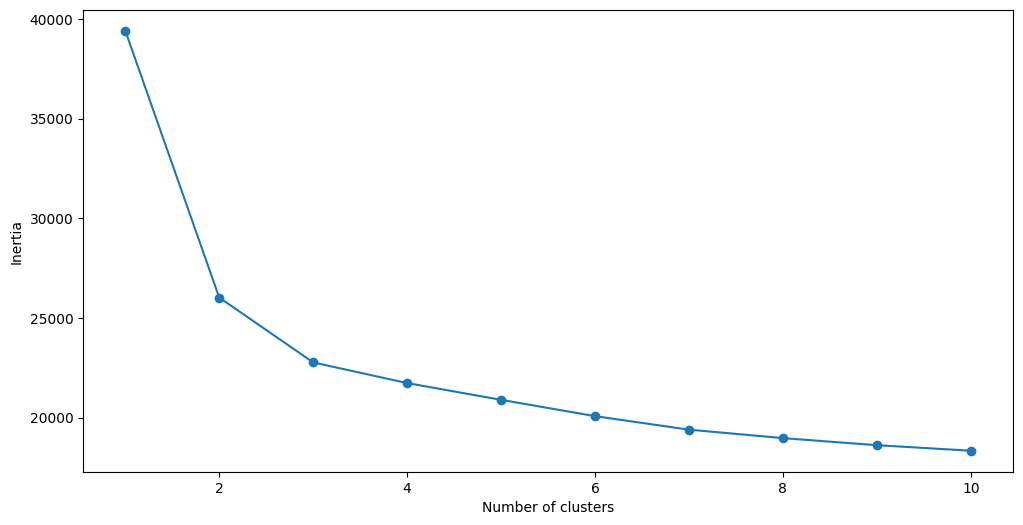

In [39]:
wcss = []

for cluster in range(1,11):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(newdf)
    wcss.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them

frame = pd.DataFrame({'Cluster':range(1,11), 'wcss':wcss})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['wcss'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

Silhouette Coefficient

A silhouette coefficient/score is a metric used to evaluate the quality of clusters created by the algorithm. The value of the silhouette coefﬁcient is between [-1, 1]. Values closer to 1 depict distinct clusters while a value closer to 0 represent poor or overlapping clusters.

A general rule of thumb is that a silhouette score above 0.5 indicates a good clustering, a silhouette score below 0.25 indicates a bad clustering, and a silhouette score between 0.25 and 0.5 indicates a fair clustering.

In [40]:
# Build model with 3 clusters
model = KMeans(n_clusters=3, init='k-means++', random_state=0).fit(newdf)
print(silhouette_score(newdf, model.labels_, metric='euclidean'))

0.2422488635725152


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


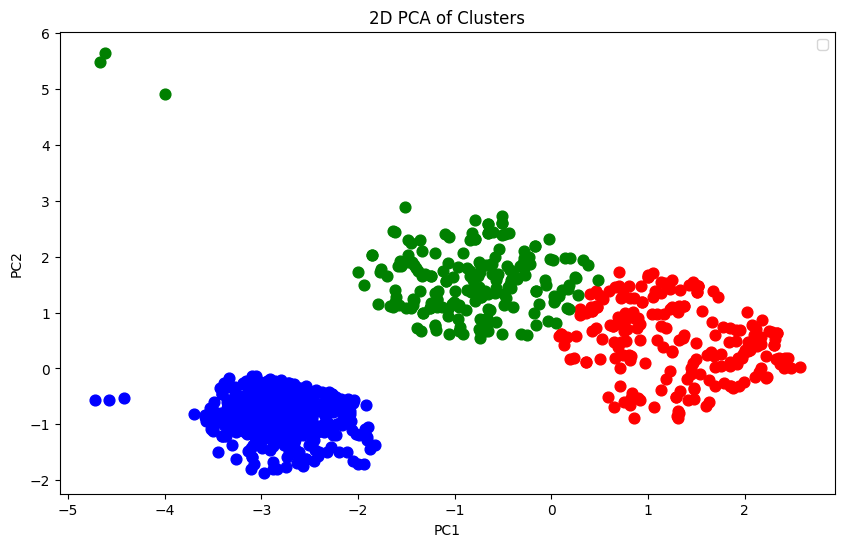

In [41]:
# Apply PCA to reduce the dimension of the dataset to 2 features for visualization

pca = PCA(n_components=2)
pca_components = pca.fit_transform(newdf)

clusters = kmeans.fit_predict(pca_components)
 
# Create a DataFrame with PCA components and cluster labels
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['label'] = clusters

plt.figure(figsize=(10,6))
plt.scatter(pca_df.PC1[pca_df.label == 0], pca_df.PC2[pca_df.label == 0], c='blue', s=60)

plt.scatter(pca_df.PC1[pca_df.label == 1], pca_df.PC2[pca_df.label == 1], c='red', s=60)
plt.scatter(pca_df.PC1[pca_df.label == 2], pca_df.PC2[pca_df.label == 2], c='green', s=60)

# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black' )

plt.xlabel('PC1')
plt.ylabel('PC2')

plt.title('2D PCA of Clusters')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


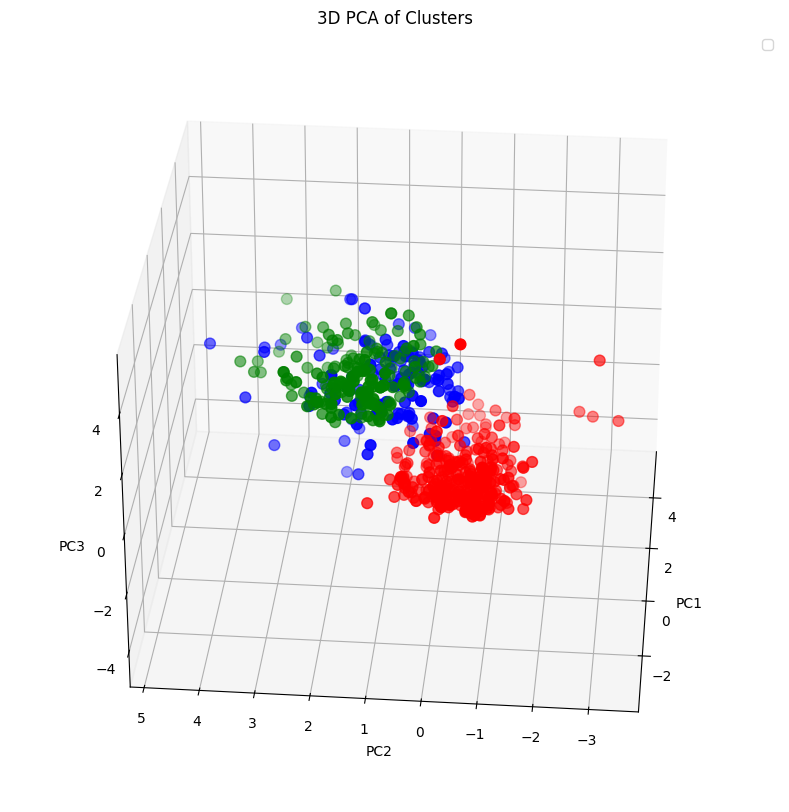

In [42]:
# Apply PCA to reduce the dimension of the dataset to 3 features for visualization

pca = PCA(n_components=3)
pca_components = pca.fit_transform(newdf)

clusters = kmeans.fit_predict(pca_components)
 
# Create a DataFrame with PCA components and cluster labels
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2', 'PC3'])
pca_df['label'] = clusters

fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df.PC1[pca_df.label == 0], pca_df.PC2[pca_df.label == 0], pca_df.PC3[pca_df.label == 0], c='blue', s=60)

ax.scatter(pca_df.PC1[pca_df.label == 1], pca_df.PC2[pca_df.label == 1], pca_df.PC3[pca_df.label == 1], c='red', s=60)
ax.scatter(pca_df.PC1[pca_df.label == 2], pca_df.PC2[pca_df.label == 2], pca_df.PC3[pca_df.label == 2], c='green', s=60)

# ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],kmeans.cluster_centers_[:, 2], s=100, c='black' )

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.view_init(30, 185)
plt.legend()
ax.set_title('3D PCA of Clusters')
plt.show()

A score of 0.24 is quite poor. We will try to get a better score  by applying PCA. 

Principal component analysis (PCA), is a dimensionality reduction technique that is often used to reduce the dimensionality of large data sets while preserving as much information as possible. 

Visualizing the result shows the cumulative variance of 0.75 (which is an acceptable amount) is achieved with 6 components. Hence, the first 6 components will be used for further analysis.

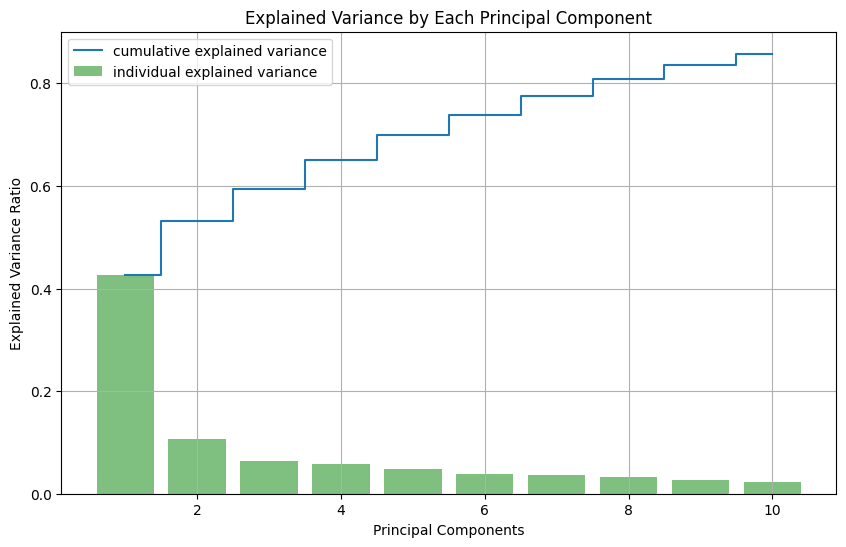

In [43]:
# Initialize PCA
pca = PCA(n_components=10)  # exploring optimal n_components by 10 components
pca_result = pca.fit_transform(newdf)

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Individual variance plot
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', color='g', label='individual explained variance')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='cumulative explained variance')
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.legend(loc='best')
plt.title('Explained Variance by Each Principal Component')
plt.grid(True)
plt.show()

Visualizing the elbow using the new data shows K is still 3.

Text(0, 0.5, 'Inertia')

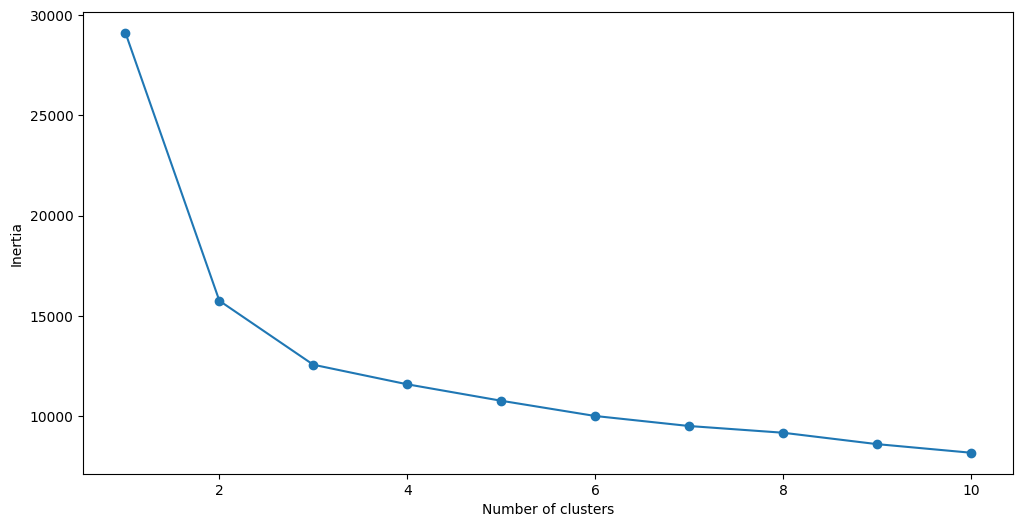

In [44]:
PCA_comp = pd.DataFrame(pca_result)

wcss = []

for cluster in range(1,11):
    kmeans = KMeans(n_clusters = cluster, init='k-means++')
    kmeans.fit(PCA_comp.iloc[:,:6])
    wcss.append(kmeans.inertia_)

# converting the results into a dataframe and plotting them

frame = pd.DataFrame({'Cluster':range(1,11), 'wcss':wcss})
plt.figure(figsize=(12,6))
plt.plot(frame['Cluster'], frame['wcss'], marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')

The new silhouette score is 0.33 which is better than the former.

In [45]:
# Build model with 3 clusters
model = KMeans(n_clusters=3, init='k-means++', random_state=0).fit(PCA_comp.iloc[:,:6])

print(silhouette_score(PCA_comp.iloc[:,:6], model.labels_, metric='euclidean'))

0.33312280491836077


Visualizing the clusters in 2D and 3D formats shows an acceptable level of grouping.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


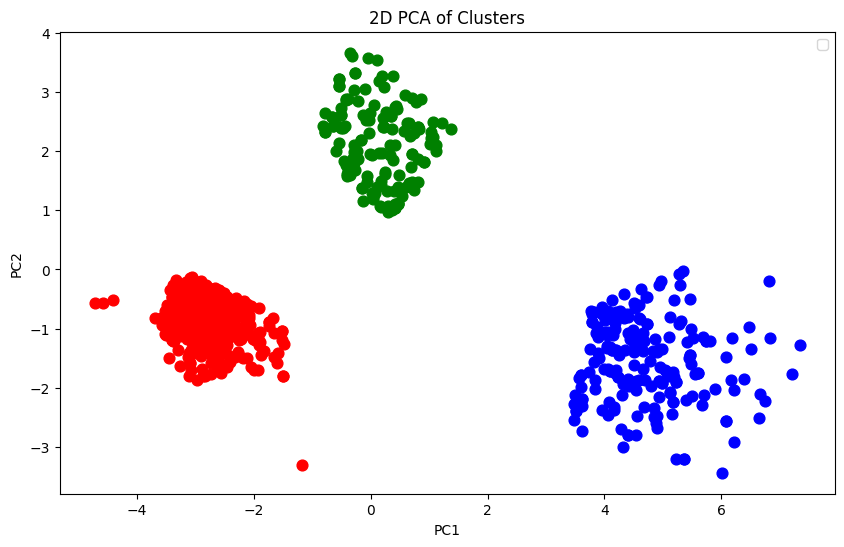

In [46]:
# Apply PCA to reduce the dimension of the dataset to 2 features for visualization

pca = PCA(n_components=2)
pca_components = pca.fit_transform(PCA_comp.iloc[:,:6])

clusters = kmeans.fit_predict(pca_components)
 
# Create a DataFrame with PCA components and cluster labels
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])
pca_df['label'] = clusters

plt.figure(figsize=(10,6))
plt.scatter(pca_df.PC1[pca_df.label == 0], pca_df.PC2[pca_df.label == 0], c='blue', s=60)

plt.scatter(pca_df.PC1[pca_df.label == 1], pca_df.PC2[pca_df.label == 1], c='red', s=60)
plt.scatter(pca_df.PC1[pca_df.label == 2], pca_df.PC2[pca_df.label == 2], c='green', s=60)

# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=100, c='black')

plt.xlabel('PC1')
plt.ylabel('PC2')

plt.title('2D PCA of Clusters')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


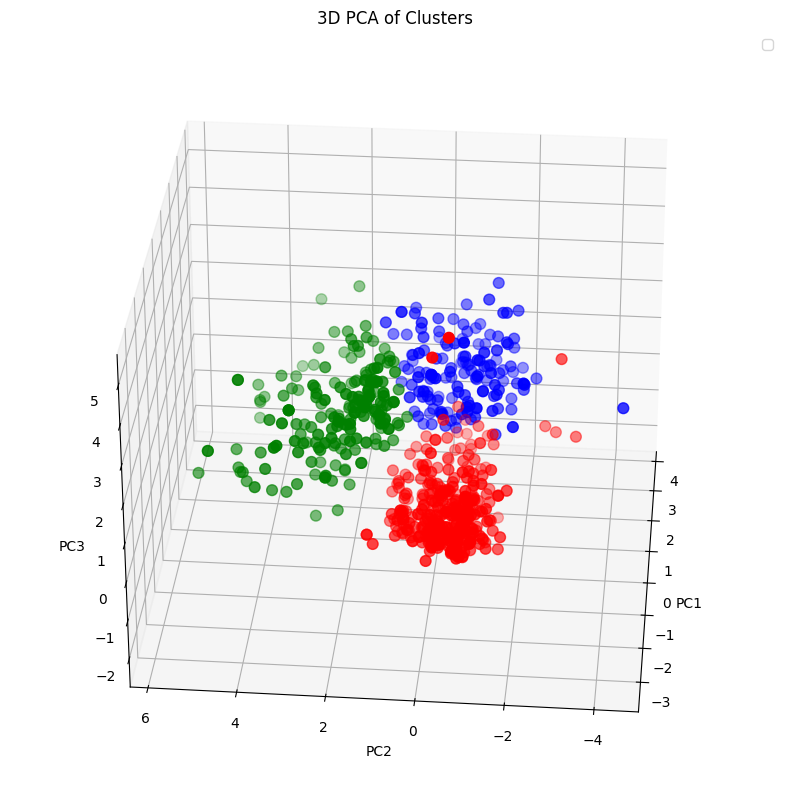

In [47]:
# Apply PCA to reduce the dimension of the dataset to 3 features for visualization

pca = PCA(n_components=3)
pca_components = pca.fit_transform(PCA_comp.iloc[:,:6])

clusters = kmeans.fit_predict(pca_components)
 
# Create a DataFrame with PCA components and cluster labels
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2', 'PC3'])
pca_df['label'] = clusters

fig = plt.figure(figsize=(21,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_df.PC1[pca_df.label == 0], pca_df.PC2[pca_df.label == 0], pca_df.PC3[pca_df.label == 0], c='blue', s=60)

ax.scatter(pca_df.PC1[pca_df.label == 1], pca_df.PC2[pca_df.label == 1], pca_df.PC3[pca_df.label == 1], c='red', s=60)
ax.scatter(pca_df.PC1[pca_df.label == 2], pca_df.PC2[pca_df.label == 2], pca_df.PC3[pca_df.label == 2], c='green', s=60)

# ax.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],kmeans.cluster_centers_[:, 2], s=100, c='black')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

ax.view_init(30, 185)
plt.legend()
ax.set_title('3D PCA of Clusters')
plt.show()

The scatter plot with the new components has better defined clusters.

The clusters are mapped to the data to enable grouping.

In [48]:
# map clusters back to dataframe

pred = model.predict(PCA_comp.iloc[:,:6])
frame = pd.DataFrame(df)
frame['Cluster'] = pred
frame.head()

,Education,Marital_Status,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Spent,is_parent,Age,Accepted,Total_Purchases,Income_Level,Age_Group,Cluster
0,Graduation,Single,58138,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,1617,No,67,1,25,Upper-Middle,60-69,1
1,Graduation,Single,46344,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,27,Yes,70,0,6,Upper-Middle,70-79,0
2,Graduation,Married,71613,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,776,No,59,0,21,Upper-Middle,50-59,1
3,Graduation,Married,26646,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,53,Yes,40,0,8,Lower-Middle,40-49,0
4,PhD,Married,58293,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,422,Yes,43,0,19,Upper-Middle,40-49,2


To understand the different clusters, the mean of the important features are first calculated

In [49]:
agg_df = frame[['Age', 'Income', 'Spent', 'Total_Purchases', 'Recency', 'Cluster']]
avg_df = agg_df.groupby(['Cluster'], as_index=False).mean()
avg_df.head()

,Cluster,Age,Income,Spent,Total_Purchases,Recency
0,0,52.718690,35157.041426,95.720617,7.787091,49.489403
1,1,55.608766,75700.610390,1371.250000,21.126623,50.259740
2,2,59.143345,56805.933447,704.675768,20.808874,47.226962


Visualising the groups

In [50]:
# List of variables for boxplots
variables = ["Age", "Income", "Spent", "Total_Purchases", "Recency"]

# Loop through each variable and create a boxplot
for var in variables:
    fig = px.bar(avg_df, x='Cluster', y=var, color='Cluster')

    fig.update_layout(
    autosize=False,
    width=500,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ))

    fig.show()

Summary of the visualization - 
- Cluster 0 - age: 52.71, income: 35.16, spent: 95.72, total_purchase: 7.78, recency: 49.49

- Cluster 1 - age: 55.61, income: 75.70, spent: 1371, total_purchase: 21.13, recency: 50.26

- Cluster 1 - age: 59.14, income: 56.81, spent: 704.68, total_purchase: 20.81, recency: 47.43

Based on the clustering results, we have three distinct customer segments based on age, income, amount spent, total purchases, and recency. Here is a breakdown of the clusters and corresponding marketing strategies:

- Cluster 0 - 
    Insights:
    * This cluster represents older customers with relatively lower incomes.
    * They have low spending and fewer total purchases.
    * Their recency score indicates moderate engagement, but not recent activity.

- Cluster 1 -
Insights:
    * This cluster consists of older customers with higher incomes.
    * They have very high spending and a large number of total purchases.
    * Their recency score shows moderate engagement, indicating potential for further engagement.

- Cluster 2 -
Insights:
    * This cluster includes the oldest customers with moderate incomes.
    * They have significant spending and a high number of total purchases.
    * Their recency score is slightly lower, indicating they might need re-engagement.

Detailed Marketing Strategy by Cluster:

* Cluster 0: Budget-Conscious Customers

    Focus: Budget-friendly offers, loyalty programs.

    Actions:
    - Launch targeted email campaigns with discount codes.
    - Offer bundled products at a reduced price.
    - Create a loyalty program with rewards for frequent purchases.


* Cluster 1: High-Value Customers

    Focus: Premium products, exclusive experiences.

    Actions:
    - Send personalized recommendations based on previous high-value purchases.
    - Offer VIP access to new product launches or exclusive events.
    - Provide premium customer support and services.

* Cluster 2: Re-engagement Candidates

    Focus: Re-engagement campaigns, seasonal promotions.

    Actions:
    - Send targeted re-engagement emails with special offers.
    - Offer time-limited discounts or early-bird specials.
    - Use direct mail to reach less digitally active customers.

======================================================================================================================================================

#### Supervised Learning

Two models - logistic regression and random forest models will be built to predict the highest profit for the next campaign

In [51]:
# relevant libraries

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

In [52]:
# Split the data into training and testing sets

X = newdf.drop('Accepted', axis=1)
y = newdf['Accepted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Logistic Regression

In [53]:
# Train a Logistic Model 
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy (Logestic Regression): {accuracy}\n{'='*70 + '>'}\nClassification Report:")

print(classification_report(y_test, y_pred))

Accuracy (Logestic Regression): 0.7566964285714286
======================================================================>
Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.90      0.84       314
           1       0.65      0.41      0.50       134

    accuracy                           0.76       448
   macro avg       0.71      0.66      0.67       448
weighted avg       0.74      0.76      0.74       448



Random Forest

In [54]:
# Train a RandomForest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy (RandomForest Classifier): {accuracy}\n{'='*70 + '>'}\nClassification Report:")

print(classification_report(y_test, y_pred))

Accuracy (RandomForest Classifier): 0.8102678571428571
======================================================================>
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.94      0.87       314
           1       0.78      0.51      0.62       134

    accuracy                           0.81       448
   macro avg       0.80      0.73      0.75       448
weighted avg       0.81      0.81      0.80       448



The random forest model performs better than the logistic regression model. While it has a higher accuracy score, the classification report indicates that the model performs better at predicting customers who did not accept the campaign (class 0) compared to those who did (class 1). The recall for class 1 is notably lower, suggesting that the model misses a significant portion of actual positive cases. 

In [55]:
# Assuming the cost per contact is 6.720/2240 = 0.003 MU and the revenue per purchase is 3.674/336 = 0.010 MU
contact_cost = 0.003
revenue_per_purchase = 0.010

# Calculate expected profit for each customer
X_test['Expected_Profit'] = y_proba * revenue_per_purchase - contact_cost

# Select customers with positive expected profit
selected_customers = X_test[X_test['Expected_Profit'] > 0]

print(f"Number of selected customers: {len(selected_customers)}")
print(f"Expected profit: {selected_customers['Expected_Profit'].sum()}")


Number of selected customers: 180
Expected profit: 0.43566928571428565


The model identified 180 customers expected to generate a positive profit. The total expected profit from these selected customers is 0.44 MU. This shows that applying the model can help target a subset of customers that are more likely to result in a profitable campaign.

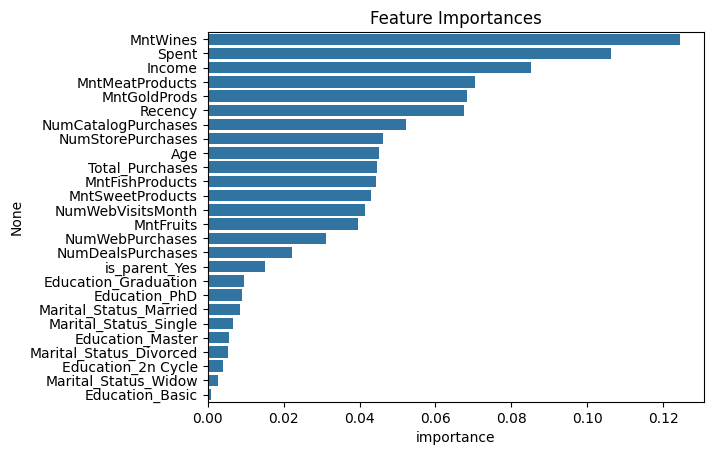

In [56]:
# Feature importance from the RandomForest model
feature_importances = pd.DataFrame(model.feature_importances_,
                                   index = X_train.columns,
                                   columns=['importance']).sort_values('importance', ascending=False)

# Plot feature importances
sns.barplot(x=feature_importances['importance'], y=feature_importances.index)
plt.title('Feature Importances')
plt.show()


Feature importances is plotted to visualize which of the features contributes the most to models performance.

To improve the performance of the random forest model, the class imbalance is addressed using SMOTE. Then the data is standardized. 

SMOTE is applied to the original feature values because it generates new data points that lie between existing minority samples. Standardizing the data before applying SMOTE might lead to synthetic data points that do not accurately reflect the original feature space.

Applying Smote, standardizing and building models

In [57]:
X = df.drop(['Accepted', 'Income_Level', 'Age_Group'], axis=1)
y = df['Accepted']

In [58]:
X_encoded = pd.get_dummies(X, drop_first=True)

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y)

scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)

# Converting back to DataFrame to retain column names
X_resampled_scaled = pd.DataFrame(X_resampled_scaled, columns=X_encoded.columns)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled_scaled, y_resampled, test_size=0.2, random_state=42)

# Train a RandomForest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_test_pred_rf = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
accuracy = accuracy_score(y_test, y_test_pred_rf)
print(f"Accuracy (RandomForest Classifier): {accuracy}\n{'='*70 + '>'}\nClassification Report:")

print(classification_report(y_test, y_test_pred_rf))

Accuracy (RandomForest Classifier): 0.9418070444104135
======================================================================>
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.94      0.94       328
           1       0.94      0.94      0.94       325

    accuracy                           0.94       653
   macro avg       0.94      0.94      0.94       653
weighted avg       0.94      0.94      0.94       653



ROC-AUC Score: 0.9898


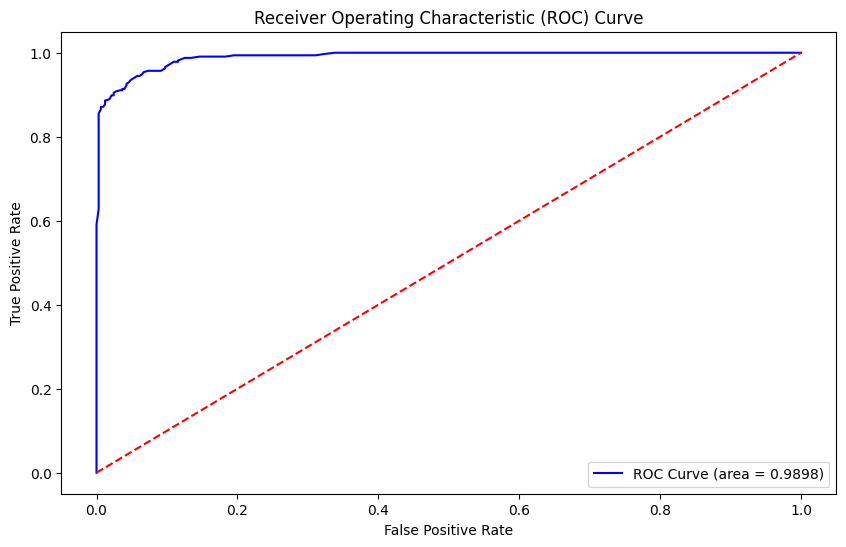

In [60]:

from sklearn.metrics import roc_curve, roc_auc_score, auc

roc_auc = roc_auc_score(y_test, y_proba)
print(f'ROC-AUC Score: {roc_auc:.4f}')

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [61]:
# Calculate metrics
metrics = {
    'model': 'RandomForestClassifier',
    'accuracy_test': accuracy_score(y_test, y_test_pred_rf),
    'precision': precision_score(y_test, y_test_pred_rf),
    'recall': recall_score(y_test, y_test_pred_rf),
    'f1_score': f1_score(y_test, y_test_pred_rf),
    'roc_auc': roc_auc_score(y_test, y_proba)
}

# Create a DataFrame
results_df = pd.DataFrame([metrics])

# Display the DataFrame
display(results_df)

,model,accuracy_test,precision,recall,f1_score,roc_auc
0,RandomForestClassifier,0.941807,0.938838,0.944615,0.941718,0.989822


In [62]:
# Predict probabilities
y_proba = model.predict_proba(X_test)[:, 1]  

# Convert X_test to DataFrame if it's not already

if not isinstance(X_test, pd.DataFrame):
    X_test_df = pd.DataFrame(X_test)  
else:
    X_test_df = X_test

# Assuming the cost per contact is 6.720/2240 = 0.003 MU and the revenue per purchase is 3.674/336 = 0.010 MU

contact_cost = 0.003
revenue_per_purchase = 0.010

# Calculate expected profit for each customer
X_test_df['Expected_Profit'] = y_proba * revenue_per_purchase - contact_cost

# Select customers with positive expected profit
selected_customers = X_test_df[X_test_df['Expected_Profit'] > 0]

print(f"Number of selected customers: {len(selected_customers)}")
print(f"Expected profit: {selected_customers['Expected_Profit'].sum()}")

Number of selected customers: 380
Expected profit: 1.9033


- Improved Targeting: By selecting 380 customers, a subset of the customer base is focused on that is most likely to generate profit. This indicates a more efficient targeting approach compared to a broad-based campaign.

- Positive Expected Profit: An expected profit of 1.9033 MU suggests that the model is effectively identifying profitable customers compared to th previous model. This is also a significant improvement compared to the pilot campaign's loss of -3.046 MU.

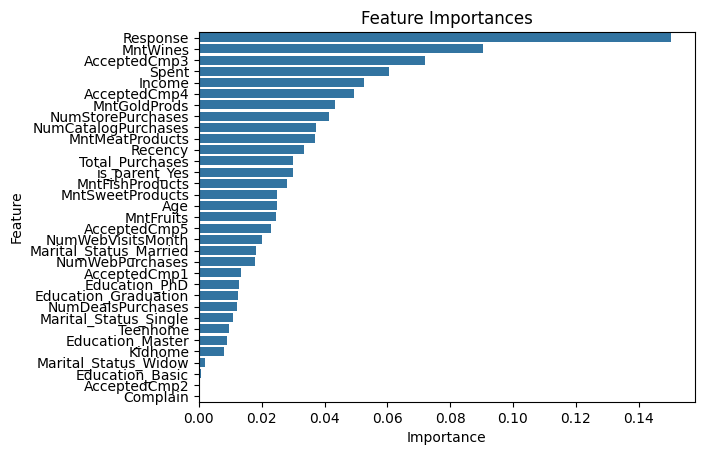

In [63]:
# Identify most important features

feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else ["feature_" + str(i) for i in range(X_train.shape[1])]

# Extract feature importances
importances = model.feature_importances_

# Create a DataFrame for plotting
feature_importances = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

# Sort by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Plotting the feature importances
# plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances)
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [64]:
# Export data to excel for further visualisations

frame.to_excel('Customer_Segmentation.xlsx', sheet_name='data')